# Lyft BayWheel Exploration
## CE 263N Project
## Authors: Tianhao Wu, Kyuri Kim
Run with environment: skmob21

# Part 1: Data Gathering and Reading
**Describe here your data sets, demonstrate what you can read it at this point and list other data sets that you may extract. Display an illustrative image of your data. (e.g a table or a plot)**

[Data source: Lyft Bay Wheels](https://www.lyft.com/bikes/bay-wheels/system-data)

Lyft provides BayWheel history data spanning year 2017 to 2021-09. Each dataset includes columns like trip duration, start/end time, start/end station ID, start/end lon&lat, user type, etc. No trajectory data is provided in this historical dataset.

The Data set includeds:
- Trip Duration (seconds)
- Start Time and Date
- End Time and Date
- Start Station ID
- Start Station Name
- Start Station Latitude
- Start Station Longitude
- End Station ID
- End Station Name
- End Station Latitude
- End Station Longitude
- Bike ID
- User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)


In this section of data gathering, We aim to achieve two tasks:
1. Load Single Month Data for data exploration
    - use method for easy adaption of another month data
    - Visualization:
        - Flow Diagram (point-point)
        - Flow Diagram (polygon-polygon)
        - "Population" Diagram. In this case frequency diagram. Heatmap of area.
2. Load Multiple data for comparison in time
    - Ultimate goal: drag time line to see development
        - Data set and computation will be huge. Might take too much resources

## Universal Method Section

In [1]:
# importing required modules
import pandas as pd
import numpy as np
import zipfile

import matplotlib.pyplot as plt

import skmob
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import Point

In [2]:
## Load Zip FIle
def LoadZipFile(file_name):
    '''
    Input: File name in string
    Output: DataFrame of the file
    '''
    # Load .zip local data
    file_name = file_name
    zip_file = zipfile.ZipFile(file_name)
    df_csv = pd.read_csv(zip_file.open(zip_file.namelist()[0])) #solve Dirty zip file
    return df_csv

def LoadZipFileRemotely(url_string):
    # Alternatively: Load .zip remotely from https
    # Take time to download

    # Example
    #LoadZipFileRemotely('https://s3.amazonaws.com/baywheels-data/202106-baywheels-tripdata.csv.zip')
    import requests, zipfile
    from urllib.request import urlopen
    from io import BytesIO

    zip_file_url = url_string
    remote_zip_file = urlopen(zip_file_url)
    zipinmemory = BytesIO(remote_zip_file.read())
    zip_file = zipfile.ZipFile(zipinmemory)

    # the zipfile namelist can be filtered for smarter file loading
    # In this case, only load the first file from the zip archive 
    df_csv_re = pd.read_csv(zip_file.open(zip_file.namelist()[0]))
    return df_csv_re

In [54]:
df_csv = LoadZipFile('data/202109-baywheels-tripdata.csv.zip')
df_csv.head(3)
print(len(df_csv))
# Crop df_csv for ease of debug & running
# NEED TO DELETE
#df_csv = df_csv.head(7000)
df_csv

212512


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,9515818787165EA3,electric_bike,2021-09-22 13:30:57,2021-09-22 13:41:40,17th & Folsom Street Park (17th St at Folsom St),SF-N23,Civic Center/UN Plaza BART Station (Market St ...,SF-I25,37.763686,-122.415521,37.780897,-122.412124,member
1,4857E21E7C02369C,electric_bike,2021-09-03 11:47:57,2021-09-03 11:54:02,The Embarcadero at Pier 38,SF-H30,4th St at 16th St,SF-M30,37.783198,-122.387994,37.767314,-122.390958,member
2,6AF0D6AC2DCF9B1B,classic_bike,2021-09-22 11:51:39,2021-09-22 12:06:54,27th St at MLK Jr Way,OK-I4,Telegraph Ave at 49th St,OK-D4,37.817015,-122.271761,37.835750,-122.262654,casual
3,B92F4F9D28E81783,docked_bike,2021-09-06 12:53:27,2021-09-06 12:59:23,The Embarcadero at Pier 38,SF-H30,The Embarcadero at Pier 38,SF-H30,37.782926,-122.387921,37.782926,-122.387921,casual
4,D5C84175F52EFBEF,classic_bike,2021-09-05 11:04:51,2021-09-05 11:09:00,The Embarcadero at Pier 38,SF-H30,Berry St at 4th St,SF-K29-1,37.782926,-122.387921,37.775880,-122.393170,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
212507,AD45EEF828F77215,electric_bike,2021-09-27 14:21:45,2021-09-27 14:26:15,Raymond Kimbell Playground,SF-G19,Sanchez St at 15th St,SF-M20,37.783738,-122.434503,37.766466,-122.431198,member
212508,85A4DDC6FD9835F4,electric_bike,2021-09-29 16:55:04,2021-09-29 17:03:08,Taylor St at 9th St,SJ-I11,San Salvador St at 9th St,SJ-N11,37.353070,-121.891971,37.334026,-121.877366,member
212509,C0938E3BE8101F62,classic_bike,2021-09-04 11:19:27,2021-09-04 11:28:41,Mission Dolores Park,SF-O21,Sanchez St at 15th St,SF-M20,37.761420,-122.426435,37.766219,-122.431060,member
212510,E653448FF05DA003,classic_bike,2021-09-15 19:44:29,2021-09-15 19:51:23,Mission Dolores Park,SF-O21,Sanchez St at 15th St,SF-M20,37.761420,-122.426435,37.766219,-122.431060,casual


In [55]:
def df_cleaning (df):
    before_cleaning = len(df)
    df.replace("", float("NaN"), inplace=True)
    df.dropna(inplace=True)
    after_cleaning = len(df)
    print('Original Dataframe has', before_cleaning, 'rows.')
    print (before_cleaning-after_cleaning, 'NaN or blank rows are dropped')
    print('Percentage of invalid rows:',np.round(100*(before_cleaning-after_cleaning)/(before_cleaning), 3),'%')
    return df

df_csv = df_cleaning(df_csv)

Original Dataframe has 212512 rows.
65699 NaN or blank rows are dropped
Percentage of invalid rows: 30.915 %


In [56]:
#COMPLETE
# Create Station reference dataframe with assigned ID
def CreateStationDF(df_csv):
    '''
    Input: df_csv
    Output: station_df
    Dataframe with tile_ID assigned at each station for reference
    Includes both start&end_station_id
    '''
    # Get unique start & end station id
    unique_station_id = pd.concat([df_csv['start_station_id'],df_csv['end_station_id']], axis=0).unique()
    # Assign arbitary index for each station
    unique_station_tile_ID = np.arange(len(unique_station_id))
    station_df = pd.DataFrame({'station_id':unique_station_id, 'tile_ID':unique_station_tile_ID})
    station_df = station_df.dropna(axis=0) # Drop NaN station_id

    return station_df
station_df = CreateStationDF(df_csv)
station_df

,station_id,tile_ID
0,SF-N23,0
1,SF-H30,1
2,OK-I4,2
3,OK-D3-1,3
4,SF-I30,4
...,...,...
459,SF-J26-2,459
460,SF-L22,460
461,SF-M22-1,461
462,SF-J15,462


In [58]:
# COMPLETE
def AddTileID2DF (df_csv, station_df):
    '''
    Input: df_csv, station_df
    Output: df_csv_new, with tile_ID included for start & end
    as column names ['tile_ID_start', 'tile_ID_end']
    '''
    ## USE PANDAS MERGE
    df_csv_new = pd.merge(df_csv, station_df, left_on='start_station_id', right_on='station_id')
    df_csv_new.rename(columns={'tile_ID':'tile_ID_start'}, inplace=True)
    df_csv_new = pd.merge(df_csv_new, station_df, left_on='end_station_id', right_on='station_id')
    df_csv_new.rename(columns={'tile_ID':'tile_ID_end'}, inplace=True)
    df_csv_new = df_csv_new.drop(['station_id_x',  'station_id_y'], axis=1)
    
    return df_csv_new

df_csv_new = AddTileID2DF(df_csv, station_df)
df_csv_new.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,tile_ID_start,tile_ID_end
0,9515818787165EA3,electric_bike,2021-09-22 13:30:57,2021-09-22 13:41:40,17th & Folsom Street Park (17th St at Folsom St),SF-N23,Civic Center/UN Plaza BART Station (Market St ...,SF-I25,37.763686,-122.415521,37.780897,-122.412124,member,0,67
1,BC612400B29A857F,classic_bike,2021-09-05 18:16:29,2021-09-05 18:26:42,17th & Folsom Street Park (17th St at Folsom St),SF-N23,Civic Center/UN Plaza BART Station (Market St ...,SF-I25,37.763735,-122.415524,37.781074,-122.411738,member,0,67
2,9629EF06B65FA57C,electric_bike,2021-09-28 10:01:42,2021-09-28 10:10:19,17th & Folsom Street Park (17th St at Folsom St),SF-N23,Civic Center/UN Plaza BART Station (Market St ...,SF-I25,37.763712,-122.415471,37.781008,-122.411916,casual,0,67
3,1173DBE2ECDE0406,electric_bike,2021-09-18 11:05:53,2021-09-18 11:16:03,17th & Folsom Street Park (17th St at Folsom St),SF-N23,Civic Center/UN Plaza BART Station (Market St ...,SF-I25,37.763746,-122.415556,37.780525,-122.412544,casual,0,67
4,1D69E65D634339B0,electric_bike,2021-09-14 13:40:21,2021-09-14 13:51:52,2nd St at Townsend St,SF-I30,Civic Center/UN Plaza BART Station (Market St ...,SF-I25,37.780517,-122.390484,37.781128,-122.411634,member,4,67


In [59]:
pd.options.mode.chained_assignment = None  # default='warn' #CANCEL WARNING MESSAGES
# NEED TO OPTIMIZE
# Having trouble intaking large data set somehow??

def CreateStationTessDF (df_csv, station_df):
    '''
    Input: df_csv, station_df
    Output: Tessellation df. A geodataframe include tile_ID, geometry
    '''

    station_df['geometry'] = ''
    station_df['start_frequency'] = ''
    station_df['return_frequency'] = ''
    for idx in np.arange(len(station_df)):
        current_station_id = station_df.iloc[idx]['station_id'] #'ABC-12' #FIXED KEY ERROR 213. stupid mistake of using loc. USE iloc for index.

        lat_array = []
        lng_array = []
        # Find lon lat of this station
        # Use both start & end station coordinates
        lat_array = np.append(lat_array, np.array(df_csv.loc[df_csv['start_station_id']==current_station_id]['start_lat']))
        lat_array = np.append(lat_array, np.array(df_csv.loc[df_csv['end_station_id']==current_station_id]['end_lat']))
        lng_array = np.append(lng_array, np.array(df_csv.loc[df_csv['start_station_id']==current_station_id]['start_lng']))
        lng_array = np.append(lng_array, np.array(df_csv.loc[df_csv['end_station_id']==current_station_id]['end_lng']))

        ## Geometry: Point or Polygon
        station_df['geometry'].loc[idx] = ArrayPoint(lng_array, lat_array)
        #station_df['geometry'][idx] = ArrayPolygon(lng_array, lat_array)

        #Frequency
        station_df['start_frequency'].loc[idx] = len(df_csv.loc[df_csv['start_station_id']==current_station_id])
        station_df['return_frequency'].loc[idx] = len(df_csv.loc[df_csv['end_station_id']==current_station_id])

        # drop '' or NaN
        #station_df
        #station_df = station_df.dropna()
        
        #gdf = gpd.GeoDataFrame(station_df,crs="EPSG:4326")
        gdf = gpd.GeoDataFrame(station_df)
        #gdf.replace("", float("NaN"), inplace=True)
        #gdf.dropna(inplace=True)
        
    return gdf

def ArrayPoint (lng_array, lat_array):
    lat_point = np.mean(lat_array)
    lng_point = np.mean(lng_array)
    return Point(lng_point, lat_point)


#####bug####
def ArrayPolygon (lng_array, lat_array):
    polygon_geom = Polygon(zip(lng_array, lat_array))
    # CAN take unorganized pair
    crs = {'init': 'epsg:4326'}
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
    return polygon

In [60]:
station_tess_df = CreateStationTessDF(df_csv_new, station_df)
station_tess_df

,station_id,tile_ID,geometry,start_frequency,return_frequency
0,SF-N23,0,POINT (-122.41551 37.76375),483,523
1,SF-H30,1,POINT (-122.38795 37.78297),635,559
2,OK-I4,2,POINT (-122.27176 37.81702),19,20
3,OK-D3-1,3,POINT (-122.26449 37.84036),100,86
4,SF-I30,4,POINT (-122.39032 37.78052),943,939
...,...,...,...,...,...
459,SF-J26-2,459,POINT (-122.40800 37.77658),713,709
460,SF-L22,460,POINT (-122.42225 37.76900),883,906
461,SF-M22-1,461,POINT (-122.42037 37.76825),440,412
462,SF-J15,462,POINT (-122.45316 37.77617),209,163


## Single Month Exploration

Now we have two dataframes:
1. Tessellation dataframe, which contains
    - tile_ID
    - frequency
    - geometry
    - station_id
2. df_csv. includes all information

We want to generate FLOW dataframe from df_csv.
Flow Dataframe includes 3 columns:

FLow, Origin, Destination

In [61]:
# Goal: Given df_csv_new, Create a flow df
# Includes
# FLow, Origin, Destination
def CreateFlowDF (df_csv):
    df_flow = df_csv.groupby(['tile_ID_start', 'tile_ID_end']).size().reset_index(name='flow')
    fdf = skmob.FlowDataFrame(df_flow,tessellation=station_tess_df, tile_id='tile_ID',origin='tile_ID_start', destination='tile_ID_end')
    return fdf

fdf = CreateFlowDF(df_csv_new)
fdf

/opt/anaconda3/envs/skmob21/lib/python3.7/site-packages/skmob/core/flowdataframe.py:145: UserWarning: The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).
  warn("The tessellation crs is None. It will be set to the default crs WGS84 (EPSG:4326).")


,origin,destination,flow
0,0,0,10
1,0,4,1
2,0,6,1
3,0,7,8
4,0,10,5
...,...,...,...
33730,462,444,1
33731,462,445,1
33732,462,460,2
33733,462,461,1


In [62]:
# Sort flow from high to low
# Select highest frequency routes to visualize
fdf_sort = fdf.sort_values(by=['flow'],ascending=False).head(100)

,station_id,tile_ID,geometry,start_frequency,return_frequency
0,SF-N23,0,POINT (-122.41551 37.76375),483,523
1,SF-H30,1,POINT (-122.38795 37.78297),635,559
2,OK-I4,2,POINT (-122.27176 37.81702),19,20
3,OK-D3-1,3,POINT (-122.26449 37.84036),100,86
4,SF-I30,4,POINT (-122.39032 37.78052),943,939
...,...,...,...,...,...
459,SF-J26-2,459,POINT (-122.40800 37.77658),713,709
460,SF-L22,460,POINT (-122.42225 37.76900),883,906
461,SF-M22-1,461,POINT (-122.42037 37.76825),440,412
462,SF-J15,462,POINT (-122.45316 37.77617),209,163


In [63]:
fdf.tessellation.head(5)

,station_id,tile_ID,geometry,start_frequency,return_frequency
0,SF-N23,0,POINT (-122.41551 37.76375),483,523
1,SF-H30,1,POINT (-122.38795 37.78297),635,559
2,OK-I4,2,POINT (-122.27176 37.81702),19,20
3,OK-D3-1,3,POINT (-122.26449 37.84036),100,86
4,SF-I30,4,POINT (-122.39032 37.78052),943,939


In [64]:
# Visualization
# https://python-visualization.github.io/folium/modules.html#module-folium.map
# https://python-visualization.github.io/folium/
# Visualize with reference of:
# skMob-FlowDataFrame.ipynb
fdf_sort.plot_flows(flow_color='red',tiles='cartodbpositron', opacity=0.25,flow_weight=2, min_flow=0, zoom=9)

![Flow Diagram](data/code-img1.png)

## A Scratch: Serviceability of stations

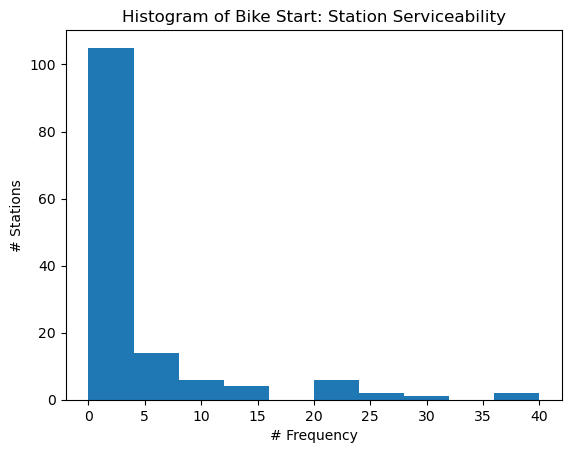

In [13]:
# Serviceability of stations
plt.hist(fdf.tessellation['start_frequency'])
plt.title('Histogram of Bike Start: Station Serviceability')
plt.ylabel('# Stations')
plt.xlabel('# Frequency')
plt.show()


## TO-DO: Time Probability Distribution (Eigenbehavior)
Given monthly data, find the probability of starting the bike during each hours of per day.

We can also reference this to MOD2 eigenbehavior

In [14]:
## TO-DO

# df_csv assign new column for hour block

# Groupby hour block for each day, aggregate size

# Plot histogram distribution

## TO-DO: Combine with census tract
Goal: Map tessellation on census tract tessellation

Each census tract includes several stations. We want to assign census tract number to each station given coordinates. 

Then use census tract tesselllation, and flow df to construct visualization.

[bayareacensus](http://www.bayareacensus.ca.gov/small/small.htm)

[census.gov](https://www2.census.gov/geo/pdfs/maps-data/data/FAQ_for_Census_Bureau_Public_Geocoder.pdf)


trgris package:
[Tigris Package](https://stackoverflow.com/questions/51499410/retrieve-census-tract-from-coordinates)

Shape File:
[census bureau](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2021&layergroup=Census+Tracts)

In [69]:
%pip install censusgeocode
import censusgeocode as cg 
# https://stackoverflow.com/questions/64983035/how-to-find-census-tract-from-latitude-and-longitude-in-python
# https://pypi.org/project/censusgeocode/

     |████████████████████████████████| 54 kB 2.9 MB/s 
Note: you may need to restart the kernel to use updated packages.


In [92]:
# Some Experiment Sample Code of cg
# Given : station_tess_df

# Access lat, lng from point object
lng = station_tess_df['geometry'].iloc[1].x
lat = station_tess_df['geometry'].iloc[1].y

# Use censusgeocode to get result of this coordinate pair
result = cg.coordinates(x=lng, y=lat)
# It will output a LONG result
#print(result)

# Access information about census tract
#result['Census Tracts'][0]

# Find TRACT value
sample_tract = result['Census Tracts'][0]['TRACT']
print('CENSUS TRACT value of given coordinate is:', sample_tract)

CENSUS TRACT value of given coordinate is 061508


In [98]:
# Complete
'''
Given tessellation dataframe about station_id
Return an extra column of this tessellation named census_tract
which is TRACT number get from censusgeocode library
'''
station_tess_df_new = station_tess_df.copy()
station_tess_df_new['census_tract'] = '' #Initialize a column
for r in np.arange(len(station_tess_df)):
    lng = station_tess_df['geometry'].iloc[r].x
    lat = station_tess_df['geometry'].iloc[r].y
    result = cg.coordinates(x=lng, y=lat)
    station_tess_df_new['census_tract'].iloc[r] = result['Census Tracts'][0]['TRACT']

station_tess_df_new

,station_id,tile_ID,geometry,start_frequency,return_frequency,census_tract
0,SF-N23,0,POINT (-122.41551 37.76375),483,523,017700
1,SF-H30,1,POINT (-122.38795 37.78297),635,559,061508
2,OK-I4,2,POINT (-122.27176 37.81702),19,20,401400
3,OK-D3-1,3,POINT (-122.26449 37.84036),100,86,400600
4,SF-I30,4,POINT (-122.39032 37.78052),943,939,060701
...,...,...,...,...,...,...
459,SF-J26-2,459,POINT (-122.40800 37.77658),713,709,017804
460,SF-L22,460,POINT (-122.42225 37.76900),883,906,020101
461,SF-M22-1,461,POINT (-122.42037 37.76825),440,412,020101
462,SF-J15,462,POINT (-122.45316 37.77617),209,163,015701


In [129]:
# Since get census take 2second per coordinate to run
# ~500 rows of dataframe takes ~10mins to run
# To save time
# I stored the value I got in the .csv file 

# Run Once
#station_tess_df_new.to_csv('station_tess_df_new.csv') 

# Read the file
station_tess_df_new = pd.read_csv('station_tess_df_new.csv')
station_tess_df_new

,Unnamed: 0,station_id,tile_ID,geometry,start_frequency,return_frequency,census_tract
0,0,SF-N23,0,POINT (-122.4155145982936 37.76374969108682),483,523,17700
1,1,SF-H30,1,POINT (-122.3879459085228 37.78297245382424),635,559,61508
2,2,OK-I4,2,POINT (-122.2717615 37.81701539999999),19,20,401400
3,3,OK-D3-1,3,POINT (-122.2644881 37.84036429999999),100,86,400600
4,4,SF-I30,4,POINT (-122.3903237474495 37.78051879624513),943,939,60701
...,...,...,...,...,...,...,...
459,459,SF-J26-2,459,POINT (-122.4080040710365 37.77658129429388),713,709,17804
460,460,SF-L22,460,POINT (-122.4222485601371 37.76900193730204),883,906,20101
461,461,SF-M22-1,461,POINT (-122.4203662890845 37.76824676007434),440,412,20101
462,462,SF-J15,462,POINT (-122.4531565216654 37.77616657708602),209,163,15701


In [125]:
# Task:
# Now we have census_tract for each station
# .groupby()
# Find shape of census tract

,station_id,tile_ID,geometry,start_frequency,return_frequency,census_tract
0,SF-N23,0,POINT (-122.41551 37.76375),483,523,017700
1,SF-H30,1,POINT (-122.38795 37.78297),635,559,061508
2,OK-I4,2,POINT (-122.27176 37.81702),19,20,401400
3,OK-D3-1,3,POINT (-122.26449 37.84036),100,86,400600
4,SF-I30,4,POINT (-122.39032 37.78052),943,939,060701
...,...,...,...,...,...,...
458,SF-A19,458,POINT (-122.43730 37.80535),551,646,012602
459,SF-J26-2,459,POINT (-122.40800 37.77658),713,709,017804
460,SF-L22,460,POINT (-122.42225 37.76900),883,906,020101
461,SF-M22-1,461,POINT (-122.42037 37.76825),440,412,020101


# Part II: Data Analysis Plan (5pts)
Which methods studied in class you plan to apply. (note: you have to distribute different measurements for each member of the projects in groups).

1. FLow Data Frame: skMob-FlowDataFrame_Oct19.ipynb
    - O-D pairs of stations
    - O-D pairs of census tract
2. Travel Behavior Analysis (Eigenbehavior)
    - Time distribution of biking
3. Trip Distribution

# Part III: Research Story (5pts)
Select a paper related with the selected dataset describe their findings here. It does not have to be exactly the same data. It is only important that you read and refer here something published about an analysis of the similar kind of network you chose. After you select a data set of your interest, we can help you to find other related articles for you to write about in you mini-project written report.

**Selected Research Paper:**

[Micromobility evolution and expansion](https://escholarship.org/content/qt96g9c9nd/qt96g9c9nd.pdf)

[Enhancing equitable service level](https://www.sciencedirect.com/science/article/abs/pii/S096669232030096X)

![OD distribution](data/rp-img1.png)

The article tracked the uses of bikes(Ford GoBike and JUMP Bike) in San Francisco. The data included origin and destination information of each trip. With that data, they figured out the frequency of use for each location and it is illustrated with images. Like this article, we came up with a figure showing the path by using origin and end location,and found out the frequency of each point. 

a change